# Import

In [6]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

# Fonctions

In [71]:
def evaluation(datas,labels,verbose=False):
    titles = ["X_train","Representation Latente","X_train_hat"]
    scores = []
    puritities = []
    rand_scores= []
    for i,data in enumerate(datas):

        shape = data.shape[1]
        nb_classes = len(np.unique(labels))

        neuro_i_1 = shape
        neuro_o_1 = shape // 2
        neuro_i_2 = shape // 2
        neuro_o_2 = shape // 4
        neuro_i_3 = shape // 4
        neuro_o_3 = nb_classes
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 50


        facteur_norma = 0.8
        lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        mseloss = MSELoss()
        CE = CrossEntropieLoss(nb_classes)
        softmax = SoftMax()


        network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
        network = Sequentiel(network_layers)

        if verbose : print("Optimisation de : ",titles[i])
        opti = Optim(network,CE,1e-2)
        opti.SGD(data,labels,batch_size,epochs)

        score = opti.getNetwork().accuracy(data,labels) 
        scores.append(score)
        if verbose : print("Accuracy sur les images issues de l'auto encodeur",score)    
        
        kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(data)
        yhat = kmeans.labels_
        
        purete = cluster_purity(yhat,labels)
        puritities.append(purete)
        
        rs  = rand_score(yhat,labels)
        rand_scores.append(rs)
        
        if verbose : 
            print("Pureté du clustering : ",purete)
            print("Rand score  : ",rs)
            print("Adjusted Rand Score : ",adjusted_rand_score(yhat,labels))
            print()

        
        
    return scores,puritities,rand_scores
        
        
        
def optimisation_espace_latent(data,labels,dim_espace_latent_list,eps,verbose=False):
    
    nb_classes = len(np.unique(labels))
    n_samples = data.shape[0]
    scores = []
    puritities = []
    rand_scores= []
    
    
    for dim_espace_latent in dim_espace_latent_list:
        

        neuro_i_1 = 256
        neuro_o_1 = 160
        neuro_i_2 = 160
        neuro_o_2 = 120
        neuro_i_3 = 120
        neuro_o_3 = 60
        neuro_i_4 = 60
        neuro_o_4 = dim_espace_latent
        
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 100
        nb_couches = 4


        facteur_norma = 0.8


        lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

        lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)

        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        BCE = BinaryCrossEntropie()


        network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                          lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
        network = Sequentiel(network_layers)

        auto_encodeur_usps = AutoEncodeur(network,BCE)

        
        if verbose : print("Dimension espace latent : ",dim_espace_latent)
        
        auto_encodeur_usps.optimisation(data,labels,batch_size,epochs,eps,False)
        
        
        
        latent_repre = auto_encodeur_usps.encode(data)
        
        datas = [latent_repre]
        score,purete,rand_score = evaluation(datas,labels,verbose)
        scores.append(score)
        puritities.append(purete)
        rand_scores.append(rand_score)
        
    return scores , puritities , rand_scores



def create_auto_encodeur(X_train,output_dim, nb_couche_lin,activations, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4):
    np.random.seed(42)
    input_dim = X_train.shape[1]
    n_samples = X_train.shape[0]
    neuro_in = [input_dim]
    neuro_out = []
    activations_enc = activations[0]
    activations_dec = activations[1]
    assert len(activations_enc) == nb_couche_lin and len(activations_dec) == nb_couche_lin
    for i in range(0,nb_couche_lin) : 
        neuro_out.append(neuro_in[::-1][0] // 2)
        neuro_in.append(neuro_out[::-1][0])
    neuro_out[-1] = output_dim
    neuro_in = neuro_in [:-1]
    modules_enc = []
    for i in range(nb_couche_lin):
        modules_enc.append(ModuleLineaire(neuro_in[i], neuro_out[i], plage_biais, facteur_norma, init=1))
        modules_enc.append(activations_enc[i])
        

    modules_dec = []
    #neuro_out = neuro_out[::-1]
    neuro_in = neuro_in[::-1]
    neuro_out = neuro_out[::-1]
    for i in range(nb_couche_lin):
        modules_dec.append(ModuleLineaire(neuro_out[i], neuro_in[i], plage_biais, facteur_norma, init=1))
        modules_dec.append(activations_dec[i])
        
    
    network = Sequentiel(modules_enc + modules_dec)
    BCE = BinaryCrossEntropie()
    auto_encodeur_usps = AutoEncodeur(network, BCE)
    auto_encodeur_usps.optimisation(X_train, X_train, batch_size, epochs,eps)
    
    return auto_encodeur_usps




def optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ):
    shape = X_train.shape[1]
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    activ = np.array([TanH,sigmoide])
    scores = []
    act_s = []
    
    
  
    for nb_layer in liste_layers:
        print("Optimisation nb_layer  : ",nb_layer)
        
        if random_activ:
            np.random.seed(42)
            activations_enc = np.random.randint(0,2,size=nb_layer)
            activations_dec = np.random.randint(0,2,size=nb_layer)

            activ_enc = activ[activations_enc]
            activ_dec = activ[activations_dec]

            activ_layer = [activ_enc,activ_dec]
        else:
            activations_enc = [TanH for _ in range(nb_layer)]
            activations_dec = [TanH for _ in range(nb_layer - 1)]
            activations_dec.append(sigmoide)
            activ_layer = [activations_enc,activations_dec]
        
        opt = create_auto_encodeur(X_train,output_dim, nb_layer,activ_layer, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)
        
        latent_repre = opt.encode(X_train)
        X_train_hat = opt.decode(latent_repre)
        
        scores.append(evaluation([X_train_hat],Y_train)[0])
        act_s.append(activ_layer)
    return scores,act_s,opt




def optimisation_network(X_train,Y_train,liste_layers,liste_dim_espace_latent,batch_size,epochs,random_activ=False,verbose=False):
    
    facteur_norma = 0.8
    plage_biais = (0,1)
    resultat_train = {}
    scores_test = []
    for output_dim in liste_dim_espace_latent :
        print("Optimisation de la dimension de l'espace latent : ",output_dim)
        resultat_train["Espace latent " +str(output_dim)] = optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ)
        print()
        l = []
        for nb_layer in liste_layers:
            l.append(resultat_train["Espace latent " +str(output_dim)][2].opti.getNetwork().accuracy(X_test,Y_test))
            
        scores_test.append(l)
    
    
    if verbose:
        plt.figure(figsize=(15,5))

        for i, output_dim in enumerate(liste_dim_espace_latent) :

            plt.subplot(1,dim_espace_latent.shape[0],i+1)

            scores = resultat_train['Espace latent '+str(output_dim)][0]
            activs = resultat_train['Espace latent '+str(output_dim)][1]
            plt.title("Accuracy de l'espace latent "+str(output_dim))
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.legend([str (a) for a in activs])
            plt.plot(liste_layers,scores)
            plt.plot(liste_layers,scores_test[i])

        plt.show()
        
        
    maximums = []
    for i, output_dim in enumerate(liste_dim_espace_latent) :
        
        scores , activations = resultat_train['Espace latent '+str(output_dim)]
        maximums.append(np.max(scores))
        
    
    dim_espace_latent_optimal = liste_dim_espace_latent[np.argmax(maximums)]
    scores = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][0]
    nb_layer_optimal = liste_layers[np.argmax(scores)]
    nb_layer_optimal_ind = np.argmax(scores)
    activ_optimal = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][1][nb_layer_optimal_ind]
    
    network_optimal = create_auto_encodeur(X_train,dim_espace_latent_optimal, nb_layer_optimal,activ_optimal, facteur_norma, plage_biais, batch_size, epochs)
    
    
    return network_optimal


In [72]:
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

In [ ]:
liste_layers = np.array([3,4,5,6])
liste_dim_espace_latent = np.array([8,10,12,14])
batch_size = 50
epochs = 50

network_optimal = optimisation_network(X_train,Y_train,liste_layers,
                                       liste_dim_espace_latent,batch_size,epochs,
                                       random_activ=False,verbose=True)

Optimisation de la dimension de l'espace latent :  8
Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.17it/s]


Optimisation nb_layer  :  4


100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Optimisation nb_layer  :  5


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


Optimisation nb_layer  :  6


 20%|████████▌                                  | 10/50 [00:18<01:09,  1.73s/it]

In [ ]:
liste_layers = np.array([3,4,5,6])
liste_dim_espace_latent = np.array([8,10,12,14])
batch_size = 50
epochs = 50

network_optimal = optimisation_network(X_train,Y_train,liste_layers,
                                       liste_dim_espace_latent,batch_size,epochs,
                                       random_activ=True,verbose=True)

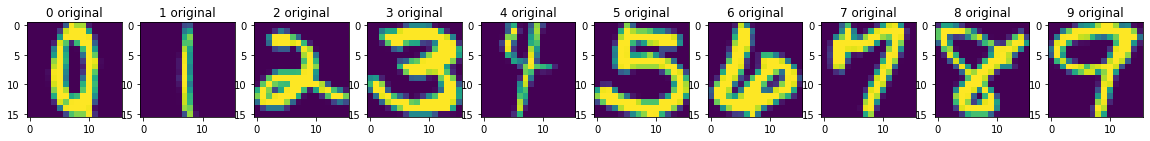

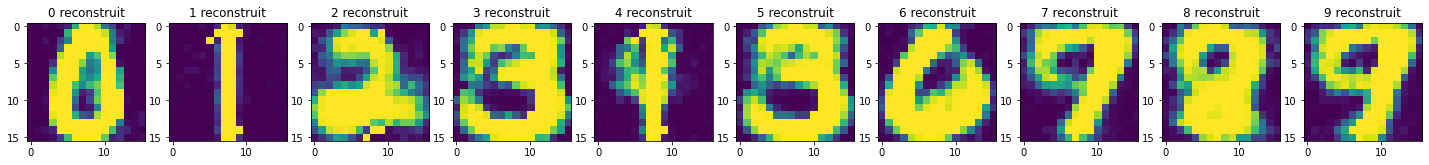

In [24]:
latent_repre = letters_auto_encodeur.encode(X_train)
X_train_hat = letters_auto_encodeur.decode(latent_repre)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

# Probleme Lineaire

### Probleme lineaire dont la frontiere de decision va passer par l'origine

In [20]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (-3, -3)
pos_sig = [[1, 4], [4, 1]]

neg_cen = (3, 3)
neg_sig = [[1, 5], [4, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)

pos_cen = (-3, -3)
pos_sig = [[2, 2], [3, 2]]

neg_cen = (3, 3)
neg_sig = [[1, 2], [4, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1151.55it/s]


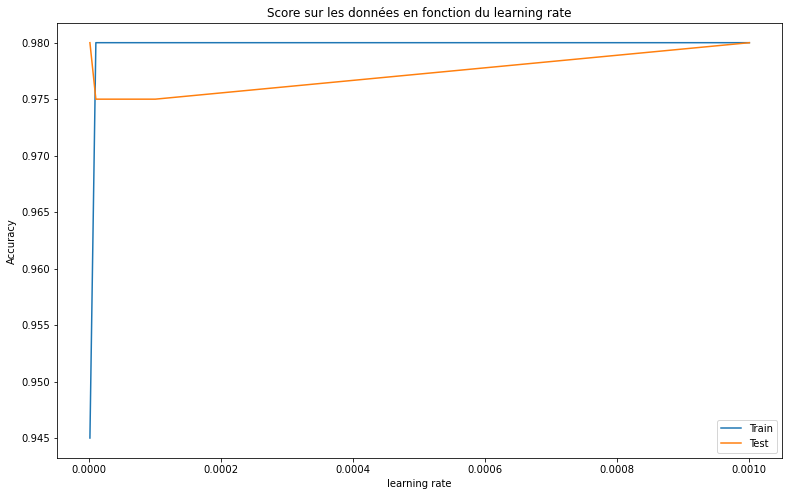

Learning rate optimal  :  0.001


In [41]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
np.random.seed(96)

neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000
rates = np.array([1e-3,1e-4,1e-5,1e-6])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data,labels,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 874.28it/s]


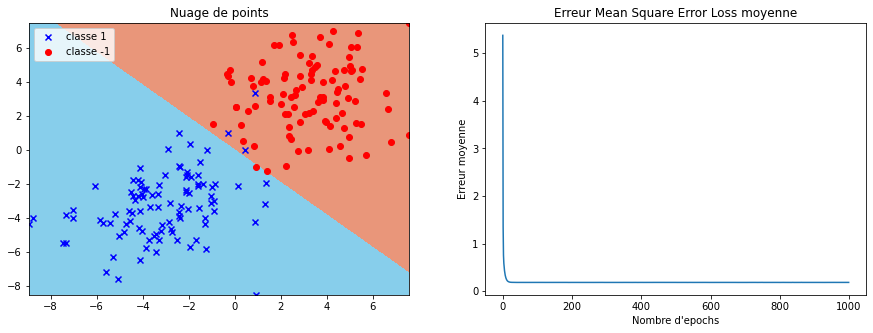

Accuracy  :  0.98


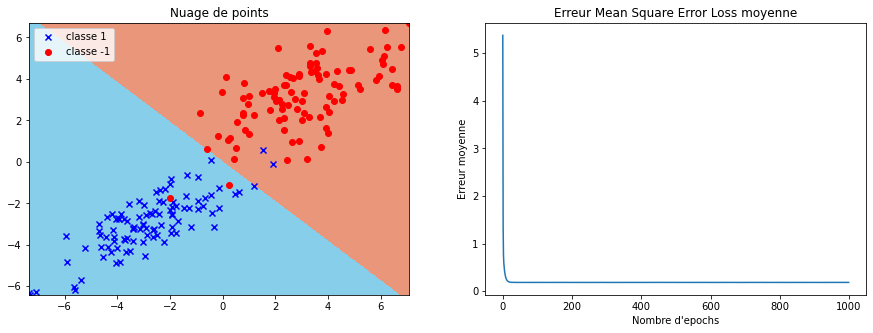

Accuracy  :  0.975


In [42]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,1e-4)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

### Probleme lineaire separable uniquement avec introduction du biais

In [52]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (3, 3)
pos_sig = [[1, 16], [16, 1]]

neg_cen = (13, 13)
neg_sig = [[1, 15], [16, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)


pos_cen = (3, 3)
pos_sig = [[2, 14], [16, 3]]
neg_cen = (13, 13)
neg_sig = [[1, 13], [17, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2563.30it/s]


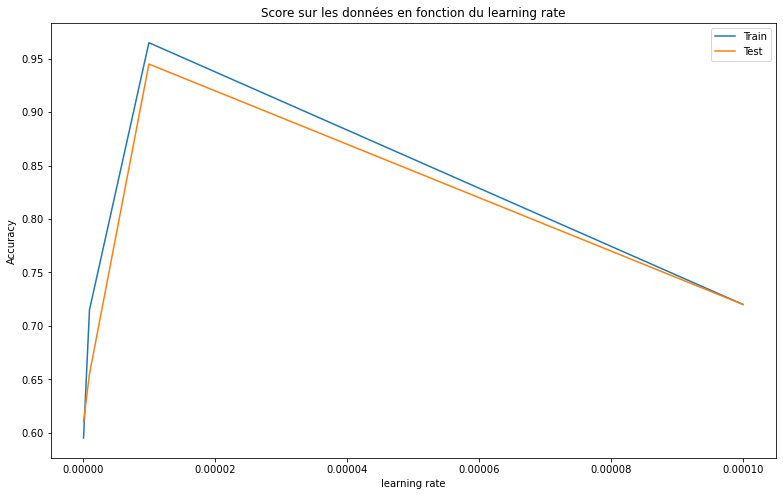

Learning rate optimal  :  1e-05


In [56]:
# definir un reseau linaire
np.random.seed(96)
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 50
epochs = 1000
rates = np.array([1e-4,1e-5,1e-6,1e-7])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data_train,labels_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 993.63it/s]


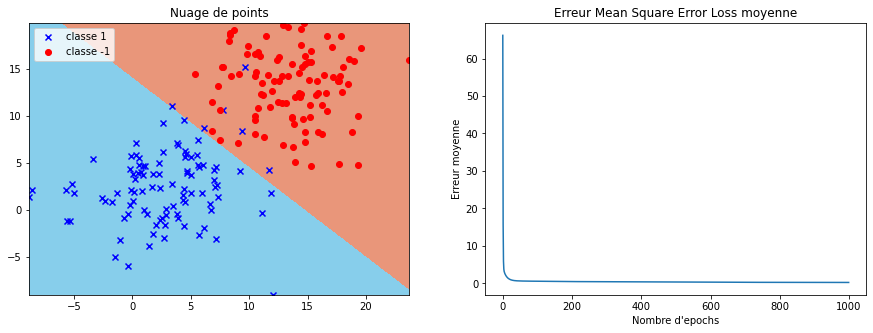

Accuracy  :  0.97


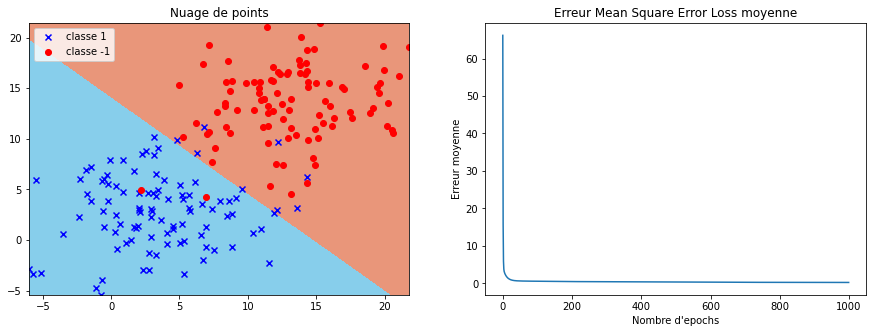

Accuracy  :  0.945


In [57]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

# Non Lineaire

### Definir un jeu de données de type XOR qui non separable lineairement 

In [60]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_xor_train , labels_xor_train = create_XOR(200,0.2)

data_xor_test , labels_xor_test = create_XOR(200,0.3)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 340.13it/s]


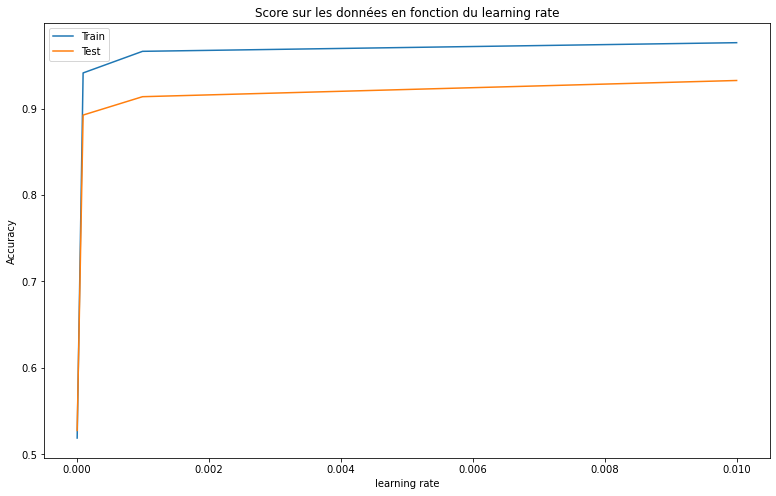

Learning rate optimal  :  0.01


In [61]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (0,1)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])
scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_xor_train,labels_xor_train))
    scores_te.append(opti.getNetwork().accuracy(data_xor_test,labels_xor_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 357.91it/s]


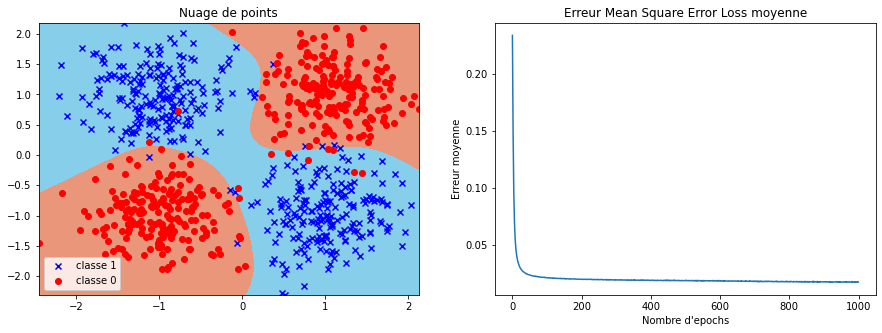

Accuracy  :  0.97625


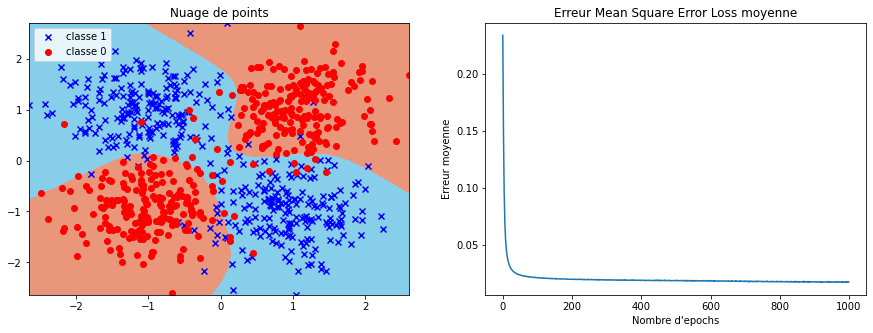

Accuracy  :  0.9325


In [63]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
opti.affichage(data_xor_train,labels_xor_train)
opti.affichage(data_xor_test,labels_xor_test)

### Definir un jeu de données de type DIRAC qui non separable lineairement 

In [69]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_dirac_train , label_dirac_train = create_data_dirac(200,0.1)
data_dirac_test , label_dirac_test = create_data_dirac(200,0.2)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 229.04it/s]


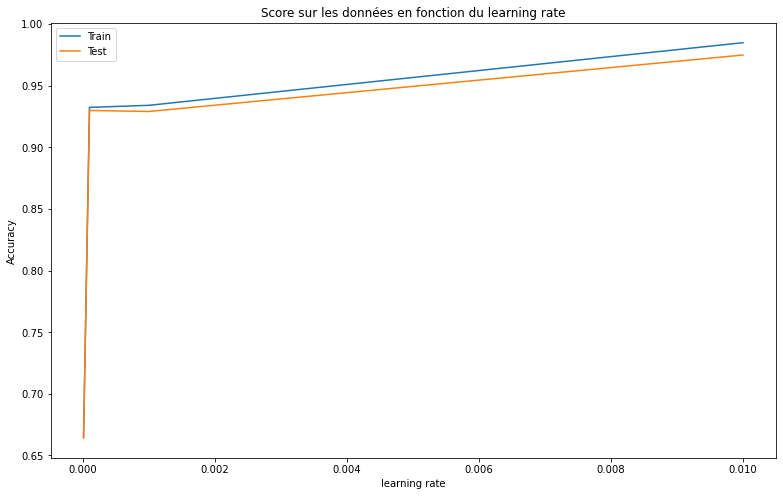

Learning rate optimal  :  0.01


In [66]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (-1,10)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])

scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_dirac_train,label_dirac_train))
    scores_te.append(opti.getNetwork().accuracy(data_dirac_test,label_dirac_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 239.48it/s]


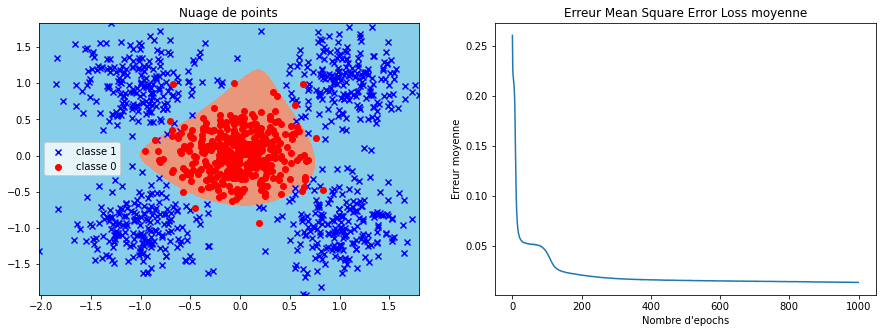

Accuracy  :  0.985


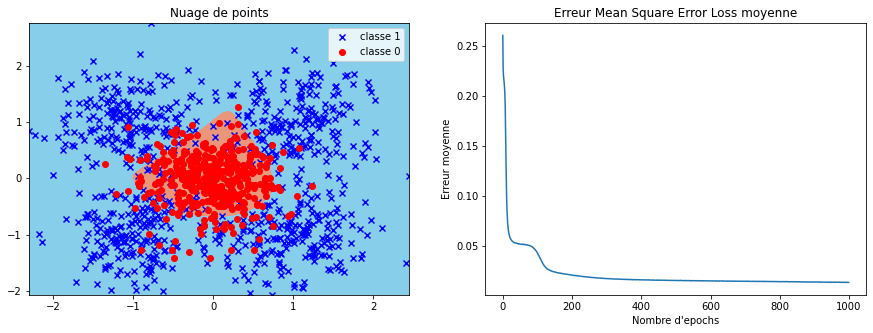

Accuracy  :  0.9016666666666666


In [70]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
opti.affichage(data_dirac_train,label_dirac_train)
opti.affichage(data_dirac_test,label_dirac_test)

# Multi Classes

### import des données USPS

In [6]:
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

### Affichage en t-SNE des données

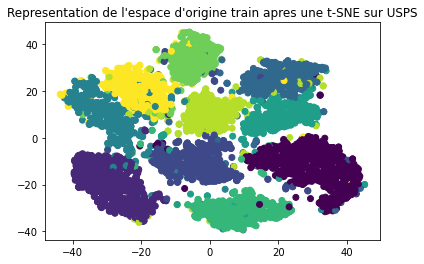

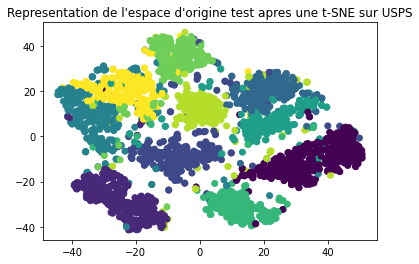

In [83]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


repre_2D = tsne.fit_transform(X_train)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine train apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
plt.show()

repre_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine test apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)
plt.show()

### definition d'une architecture 

100%|███████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


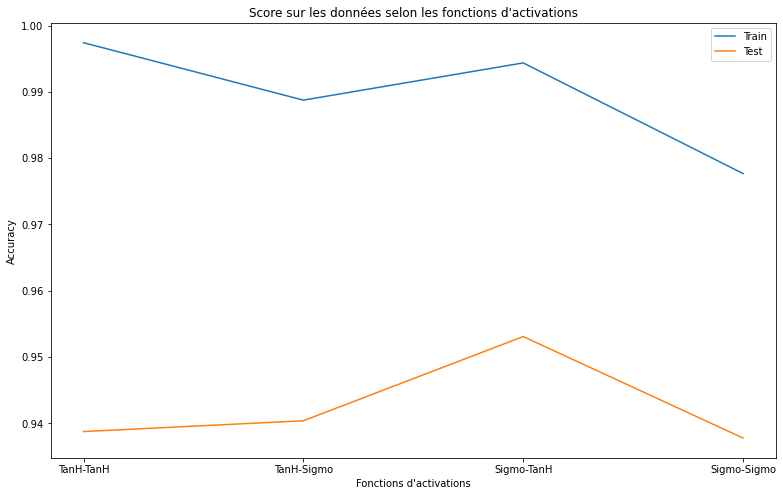

In [94]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 20
epochs = 50

scores_tr = []
scores_te = []
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()
activations = [[TanH,TanH],[TanH,sigmoide],[sigmoide,TanH],[sigmoide,sigmoide]]
fonctions = ["TanH-TanH","TanH-Sigmo","Sigmo-TanH","Sigmo-Sigmo"]

for activa in activations:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)

    network_layers = [lineaire_1,activa[0],lineaire_2,activa[1],lineaire_3,softmax]
    network = Sequentiel(network_layers)

    opti = Optim(network,CE,1e-2)
    opti.SGD(X_train,Y_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(X_train,Y_train))
    scores_te.append(opti.getNetwork().accuracy(X_test,Y_test)) 
    
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données selon les fonctions d'activations")
plt.xlabel("Fonctions d'activations")
plt.ylabel("Accuracy")
plt.plot(fonctions,scores_tr)
plt.plot(fonctions,scores_te)
plt.legend(["Train","Test"])
plt.show()

- On remarque qu'en mettant une sigmoide pour la premiere couche et une autre sigmoide pour la deuxieme couche donne des resultats plus interessants vu que la generalisation sur le probleme est plus grande (97% train , 93% test) par rapport aux autres combinaisons de fonction d'activations.

### Evaluation du reseau optimal

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.74it/s]


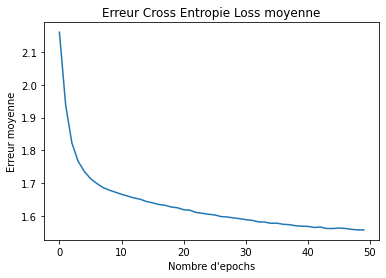

Accuracy  :  0.9733504575373254
Accuracy sur le train :  0.9733504575373254
Accuracy sur le test :  0.9341805148256761


In [99]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,sigmoide,lineaire_2,sigmoide,lineaire_3,softmax]
network = Sequentiel(network_layers)

opti = Optim(network,CE,1e-2)
opti.SGD(X_train,Y_train,batch_size,epochs)
opti.affichage(X_train,Y_train)


print("Accuracy sur le train : ",opti.getNetwork().accuracy(X_train,Y_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(X_test,Y_test))

In [110]:
Y_pred = opti.getNetwork().predict(X_train,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_train)
yhat = kmeans.labels_

print("TRAIN\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(yhat,Y_train))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(yhat,Y_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(yhat,Y_train))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(yhat,Y_pred))



print("--------------------------------------------")


Y_pred = opti.getNetwork().predict(X_test,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_test)
yhat = kmeans.labels_

print("\nTEST\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(yhat,Y_test))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(yhat,Y_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(yhat,Y_test))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(yhat,Y_pred))



TRAIN

Purete du clustering de Kmeans sur les labels USPS :  0.7068550329105795
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7147214641194414

Rand_score du clustering de Kmeans sur les labels USPS :  0.9131695728218426
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.9152282819921693
--------------------------------------------

TEST

Purete du clustering de Kmeans sur les labels USPS :  0.7057673509286413
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7194525904203324

Rand_score du clustering de Kmeans sur les labels USPS :  0.9126345679106751
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.915274203956544


- On remarque que les metrics de clusterig ( purete et rand score ) donnent pratiquement les meme resultats sur les labels d'origine des données USPS et sur les labels predits par le reseau optimisé , ce qui prouve que le reseau a bien ete optimisé et a ete bien generale sur les données de test.

# Auto-Encodeur

### Optimisation de l'espace latent

In [7]:
dim_espace_latent_list = [10,20,30,40,50]
scores,purities,rand_scores = optimisation_espace_latent(X_train,Y_train,dim_espace_latent_list,1e-4)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 22.83it/s]


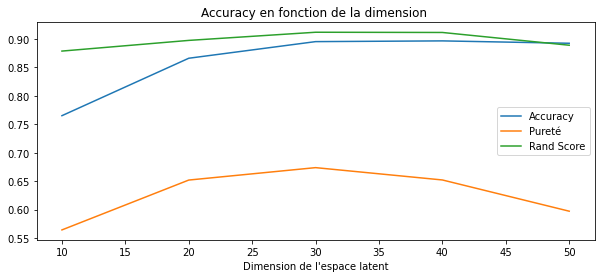

In [8]:
dim_espace_latent_list = np.array([10,20,30,40,50])

plt.figure(figsize=(10,4))
plt.plot(dim_espace_latent_list[np.arange(len(scores))],scores)
plt.plot(dim_espace_latent_list[np.arange(len(scores))],purities)
plt.plot(dim_espace_latent_list[np.arange(len(scores))],rand_scores)
plt.title("Accuracy en fonction de la dimension ")
plt.legend(["Accuracy","Pureté","Rand Score"])
plt.xlabel("Dimension de l'espace latent")
plt.show()

In [9]:
dim_espace_latent_optimal = 20

### Creation de l'architecture du reseau avec la dimension de l'espace optimale

In [ ]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 160
neuro_i_2 = 160
neuro_o_2 = 120
neuro_i_3 = 120
neuro_o_3 = 60
neuro_i_4 = 60
neuro_o_4 = dim_espace_latent_optimal
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 100
epochs = 100
nb_couches = 4



lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
BCE = BinaryCrossEntropie()


network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                  lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
network = Sequentiel(network_layers)

auto_encodeur_usps = AutoEncodeur(network,BCE)

auto_encodeur_usps.optimisation(X_train,Y_train,batch_size,epochs,1e-4)


latent_repre = auto_encodeur_usps.encode(X_train)
X_train_hat = auto_encodeur_usps.decode(latent_repre)